# Tom and jerry, loading dataset

## Imports

In [1]:
import kagglehub

import keras

import tensorflow as tf

from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2

from matplotlib import pyplot as plt
import numpy as np

import datetime


from pathlib import Path


/Users/ramin/miniconda3/envs/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
! rm -rf ./logs/

In [3]:
%load_ext tensorboard

In [4]:
%tensorboard --logdir logs/fit

## Get the data

In [5]:
path = Path(kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification"))

In [6]:
data_path = path / "tom_and_jerry/tom_and_jerry"

## Load data

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Using 1095 files for validation.
--------------------
train_data_batch_size: 293
valid_data_batch_size: 73
test_data_batch_size: 92


2024-11-21 13:48:42.086174: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-21 13:48:42.086202: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-21 13:48:42.086209: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-21 13:48:42.086224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 13:48:42.086234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


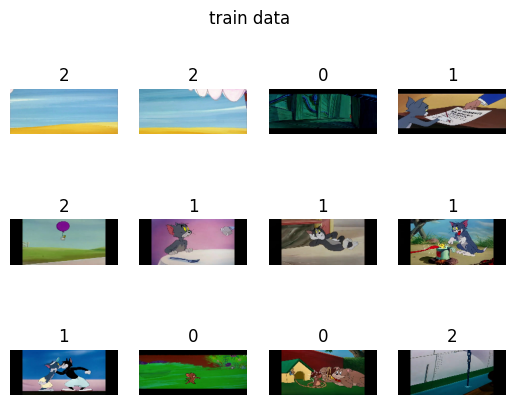

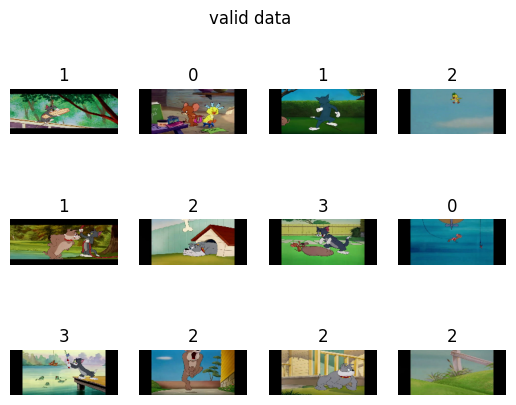

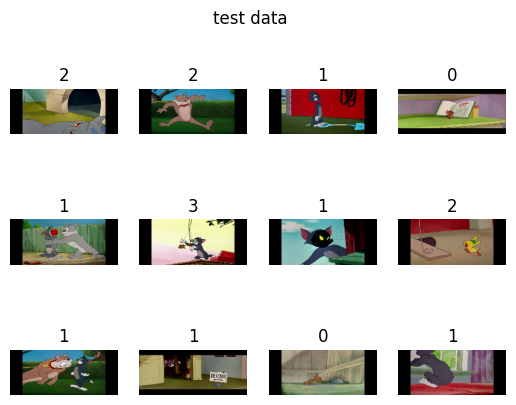

In [7]:
BATCHSIZE = 12

all_train_data, test_data = keras.utils.image_dataset_from_directory(
    data_path,
    seed=10,
    validation_split=0.2,
    subset="both",
    batch_size=BATCHSIZE,
    image_size=(80, 190),
    shuffle=True,
)

train_data_size = np.ceil(all_train_data.cardinality().numpy() * 0.8)

train_data = all_train_data.take(train_data_size)
valid_data = all_train_data.skip(train_data_size)

print("-" * 20)
print(f"train_data_batch_size: {train_data.cardinality().numpy()}")
print(f"valid_data_batch_size: {valid_data.cardinality().numpy()}")
print(f"test_data_batch_size: {test_data.cardinality().numpy()}")

# show one batch of train data
images, labels = next(iter(train_data.take(1)))

fig, axes = plt.subplots(3, 4)

fig.suptitle("train data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    axes_ravel[i].set_title(f"{label}")

# show one batch of validation data
images, labels = next(iter(valid_data.take(1)))

fig, axes = plt.subplots(3, 4)

fig.suptitle("valid data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    axes_ravel[i].set_title(f"{label}")

plt.show()

# show one batch of test data
images, labels = next(iter(test_data.take(1)))

fig, axes = plt.subplots(3, 4)

fig.suptitle("test data")

axes_ravel = axes.ravel()

for i, (image, label) in enumerate(zip(images, labels)):
    axes_ravel[i].imshow(image.numpy().astype("uint8"))
    axes_ravel[i].set_axis_off()
    axes_ravel[i].set_title(f"{label}")

plt.show()

## Transfer learning

In [8]:
base_model = MobileNetV2(include_top=False)

base_model.trainable = False

model = Sequential(
    [
        Input(shape=(80, 190, 3)),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(4, activation="softmax"),
    ],
)


opt = keras.optimizers.Adam()
# opt = keras.optimizers.SGD()

model.compile(
    optimizer=opt,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)


print(model.summary(show_trainable=True))

/var/folders/wc/xkpkldpn6jl553z8rdtp0c_c0000gn/T/ipykernel_4940/2782106045.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mobilenetv2_1.00_224        │ (None, 2, 5, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 4)             │      5,124 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


## Train

In [9]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_data,
    epochs=20,
    validation_data=(valid_data),
    callbacks=[tensorboard_callback],
)

Epoch 1/20


2024-11-21 13:48:50.794126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


293/293 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3105 - loss: 1.8690 - val_accuracy: 0.4579 - val_loss: 1.2063
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.4645 - loss: 1.2935 - val_accuracy: 0.5040 - val_loss: 1.1487
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5050 - loss: 1.1698 - val_accuracy: 0.5525 - val_loss: 1.0794
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5146 - loss: 1.1271 - val_accuracy: 0.5444 - val_loss: 1.0853
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5580 - loss: 1.0676 - val_accuracy: 0.5156 - val_loss: 1.1345
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5760 - loss: 1.0213 - val_accuracy: 0.5998 - val_loss: 1.0335
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5847 - loss: 1.0074 - val_accuracy: 0.5421 - val_loss: 1.1125
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5825 - loss: 1.0068 - val_accuracy: 0.57

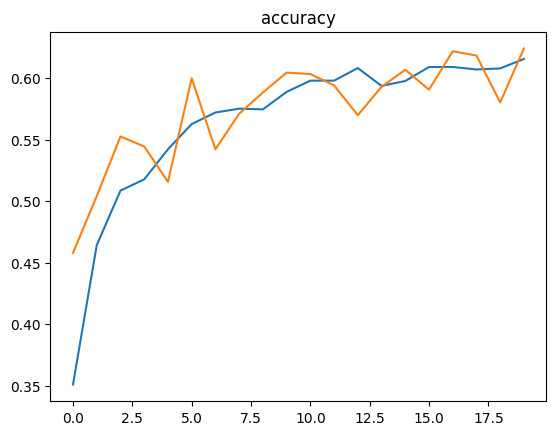

In [10]:
plt.figure()

plt.title("accuracy")

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.show()

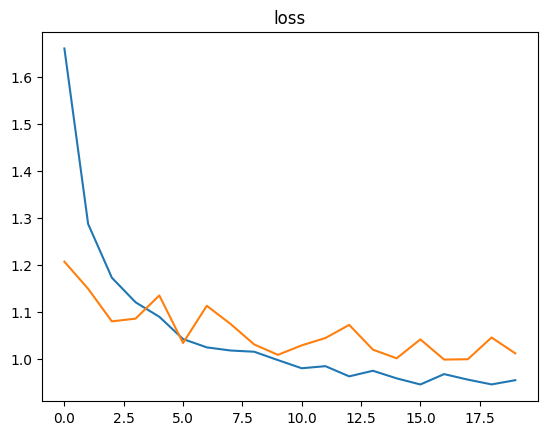

In [11]:
plt.figure()

plt.title("loss")

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.show()

In [12]:
model.evaluate(test_data)

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5917 - loss: 0.9829


[0.9713732004165649, 0.6036529541015625]